# PreliminaryPerformanceAnalysis

Here, I assess the behavior of a settings management tool for Tesseract, with the major constraint that **the ground truth -- correctly transcribed texts -- is currently unavailable**.

The following document was used to guide this design process:
* [development_sample.pdf](https://drive.google.com/file/d/19OQOaOqkOJTCBwS7829HHMqscgMxqUKH/view?usp=sharing)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/

/content/drive/.shortcut-targets-by-id/1W2EROe2FItlaK99U-WY_qaBOc2UD_LI0/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr


In [3]:
!apt-get install g++ protobuf-compiler libprotobuf-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libprotobuf-dev is already the newest version (3.0.0-9.1ubuntu1).
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
g++ is already the newest version (4:7.4.0-1ubuntu2.3).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.


In [6]:
!pip install -r requirements.txt

     |████████████████████████████████| 115 kB 33.6 MB/s 
     |████████████████████████████████| 870 kB 31.7 MB/s 
     |████████████████████████████████| 647 kB 37.7 MB/s 
     |████████████████████████████████| 122 kB 65.4 MB/s 
     |████████████████████████████████| 786 kB 74.5 MB/s 
     |████████████████████████████████| 121 kB 69.4 MB/s 
     |████████████████████████████████| 122 kB 62.2 MB/s 
     |████████████████████████████████| 243 kB 54.0 MB/s 
     |████████████████████████████████| 981 kB 53.8 MB/s 
     |████████████████████████████████| 10.3 MB 49.0 MB/s 
     |████████████████████████████████| 15.7 MB 187 kB/s 
     |████████████████████████████████| 11.3 MB 49.6 MB/s 
     |████████████████████████████████| 10.1 MB 69.2 MB/s 
     |████████████████████████████████| 3.0 MB 40.9 MB/s 
     |████████████████████████████████| 6.4 MB 27.6 MB/s 
     |████████████████████████████████| 62 kB 875 kB/s 
     |████████████████████████████████| 28.5 MB 52 kB/s 
     |████████

In [3]:
from tesseract_manager import Text
import pickle
import matplotlib.pyplot as plt
import statistics
import pandas as pd

## Iteration 0

Here, I characterize the zeroth tested iteration of the system.

The qualitative analysis, which was more informative and important, can be found in [this spreadsheet](https://docs.google.com/spreadsheets/d/1-Pao75iP8Kbb-DsW-uKg1BcN0PFCr8HR7qK3FK2LXPk/edit?usp=sharing) -- especially in the "Notes" and "Solved by" columns.

In [ ]:
with open('development_sample_out/analysis.pickle', 'rb') as dbfile:
  it0 = pickle.load(dbfile)
it0

In [ ]:
mean_confidences = list(
    conf for conf in it0.mean_confidences if not pd.isna(conf))
print('The mean wordwise confidence was {:.4f},\nthe mean pagewise confidence '
  'was {:.4f},\nand {} pages were analyzed with a confidence of less than '
  '75.'.format(
      statistics.mean(
          confidence
          for data in [data for data in it0.metadata if data is not None]
          for confidence in data.conf if confidence > -1
      ),
      statistics.mean(mean_confidences),
      sum(conf < 75 for conf in mean_confidences)
  ))

The mean wordwise confidence was 87.3667,
the mean pagewise confidence was 85.1585,
and 32 pages were analyzed with a confidence of less than 75.


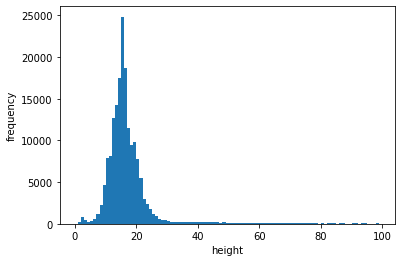

In [ ]:
all_heights = [
           height
           for data in [data for data in it0.metadata if data is not None]
           for height in data.height
]
plt.hist(all_heights, bins=list(range(100)))
plt.xlabel('height')
plt.ylabel('frequency');

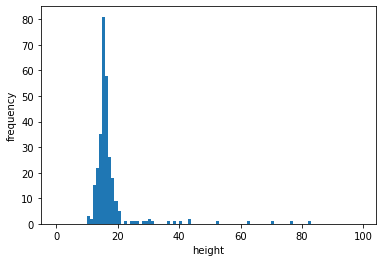

In [ ]:
median_heights = [
           data.height.median()
           for data in [data for data in it0.metadata if data is not None]
]
plt.hist(median_heights, bins=list(range(100)))
plt.xlabel('height')
plt.ylabel('frequency');

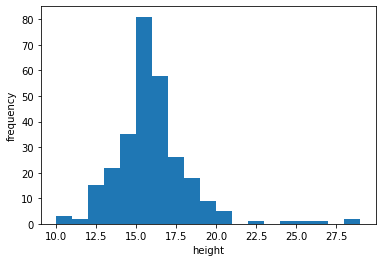

In [ ]:
plt.hist(median_heights, bins=list(range(10, 30)))
plt.xlabel('height')
plt.ylabel('frequency');

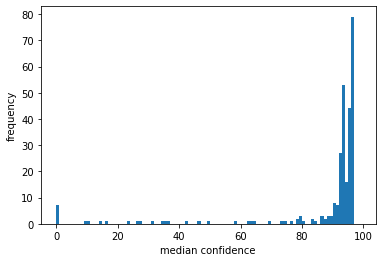

In [ ]:
median_confidences = [
           data.conf.median()
           for data in [data for data in it0.metadata if data is not None]
]
plt.hist(median_confidences, bins=list(range(100)))
plt.xlabel('median confidence')
plt.ylabel('frequency');

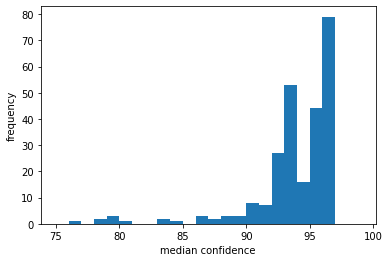

In [ ]:
plt.hist(median_confidences, bins=list(range(75, 100)))
plt.xlabel('median confidence')
plt.ylabel('frequency');

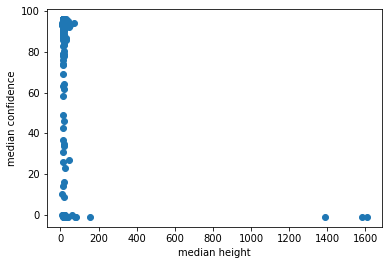

In [ ]:
plt.scatter(median_heights, median_confidences)
plt.xlabel('median height')
plt.ylabel('median confidence');

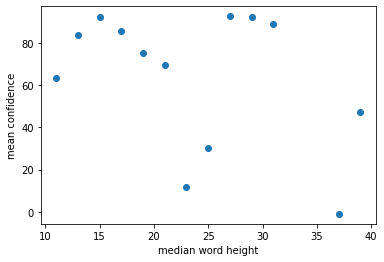

In [ ]:
movmeans = []
bins = []
for lower in list(range(10, 40, 2)):
  bin = [median_confidences[i] for i, height in enumerate(median_heights) if lower <= height <= lower+2]
  if bin:
    movmeans.append(sum(bin) / len(bin))
    bins.append(lower+1)
plt.scatter(bins, movmeans)
plt.ylabel('mean confidence')
plt.xlabel('median word height');

The above is worth comparing with [this result](https://groups.google.com/g/tesseract-ocr/c/Wdh_JJwnw94/m/24JHDYQbBQAJ).

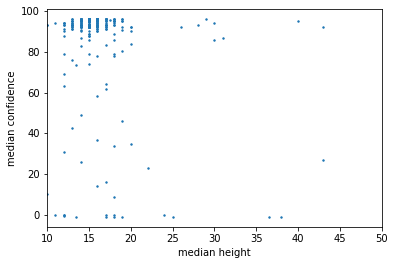

In [ ]:
plt.scatter(median_heights, median_confidences, s=2)
plt.xlabel('median height')
plt.ylabel('median confidence')
plt.xlim(10, 50);

The above indicates that it seems not uncommon that texts outside of the apparently optimal range are sometimes analyzed with high confidence.

# Iteration 1

In iteration 0, I found that a mostly correct result was sometimes being replaced by a completely incorrect result by the OSD-assisted analysis -- typically because the detected script or orientation was wrong. Here, I amend that by ensuring that results with moderate confidences are not replaced by results with lower confidences.

See [this spreadsheet](https://docs.google.com/spreadsheets/d/1SjVziDjYV4YPSSdjaHtBeGsaBVx-zjgcDK430V-aMrY/edit?usp=sharing) for the output.

In [ ]:
with open('development_sample_out3/analysis.pickle', 'rb') as dbfile:
  it1 = pickle.load(dbfile)
it1

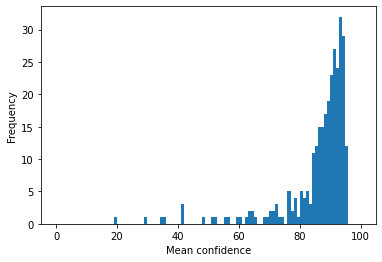

In [ ]:
plt.hist([conf for conf in it1.mean_confidences if conf is not None], bins=range(101))
plt.xlabel('Mean confidence')
plt.ylabel('Frequency');

In [ ]:
mean_confidences = list(
    conf for conf in it1.mean_confidences if not pd.isna(conf))
print('The mean wordwise confidence was {:.4f},\nthe mean pagewise confidence '
  'was {:.4f},\nand {} pages were analyzed with a confidence of less than '
  '75.'.format(
      statistics.mean(
          confidence
          for data in [data for data in it1.metadata if data is not None]
          for confidence in data.conf if confidence > -1
      ),
      statistics.mean(mean_confidences),
      sum(conf < 75 for conf in mean_confidences)
  ))

The mean wordwise confidence was 88.3453,
the mean pagewise confidence was 86.2748,
and 31 pages were analyzed with a confidence of less than 75.


This shows that there was a small improvement.

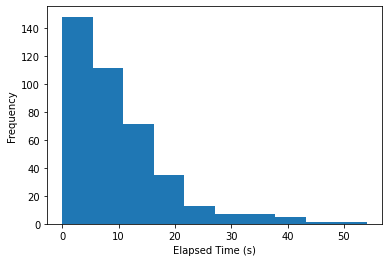

In [ ]:
times = [it1.times[i] - it1.times[i-1] for i in range(1, len(it1.times))]
plt.hist(times)
plt.xlabel('Elapsed Time (s)')
plt.ylabel('Frequency');

In [ ]:
statistics.mean(times)

9.366165890131978

## Iteration 2

Here, I arrange for the system to choose an empirically optimal image scale. The goal is to observe an accuracy improvement -- which can indirectly be observed with confidence scores (although one must, of course, be careful).

See [this spreadsheet](https://docs.google.com/spreadsheets/d/1LGHUcjmFuXFwDovforib0Sn7f9CqoLdhsELzhzS1CN8/edit?usp=sharing) for the output.

In [ ]:
with open('development_sample_out4/analysis.pickle', 'rb') as dbfile:
  it2 = pickle.load(dbfile)
it2

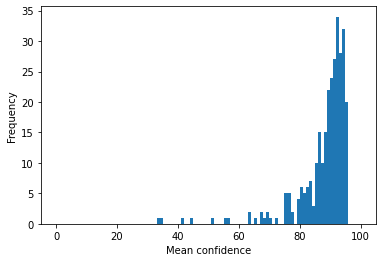

In [ ]:
plt.hist([conf for conf in it2.mean_confidences if conf is not None], bins=range(101))
plt.xlabel('Mean confidence')
plt.ylabel('Frequency');

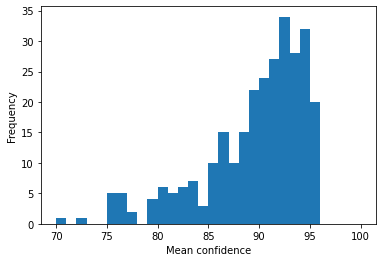

In [ ]:
plt.hist([conf for conf in it2.mean_confidences if conf is not None], bins=range(70, 101))
plt.xlabel('Mean confidence')
plt.ylabel('Frequency');

Right here, I think that I may see a subtle reflection of the special number 75: The value I chose in my program to be the cutoff between acceptable results and results that needed additional attention. Part of this "additional attention" is rescaling.

In [ ]:
mean_confidences = list(
    conf for conf in it2.mean_confidences if not pd.isna(conf))
print('The mean wordwise confidence was {:.4f},\nthe mean pagewise confidence '
  'was {:.4f},\nand {} pages were analyzed with a confidence of less than '
  '75.'.format(
      statistics.mean(
          confidence
          for data in [data for data in it2.metadata if data is not None]
          for confidence in data.conf if confidence > -1
      ),
      statistics.mean(mean_confidences),
      sum(conf < 75 for conf in mean_confidences)
  ))

The mean wordwise confidence was 89.0195,
the mean pagewise confidence was 87.9094,
and 17 pages were analyzed with a confidence of less than 75.


Confidence scores increased.

There was also a marked decrease in the number of pages that were analyzed with very low confidence. 17 pages out of 400 is only 4.25%. However, this may have occurred partly because failures may not be registered if no words or only easy words are detected while difficult words are ignored. I think this suggests that the metric that I use to determine the "goodness" of a result needs to be revised.

In [ ]:
print(it2.metadata[90])

   level  page_num  block_num  par_num  line_num  ...  top  width  height  conf  text
0      1         1          0        0         0  ...    0    902     686    -1   NaN
1      2         1          1        0         0  ...    0    684     686    -1   NaN
2      3         1          1        1         0  ...    0    684     686    -1   NaN
3      4         1          1        1         1  ...    0    684     686    -1   NaN
4      5         1          1        1         1  ...    0    684     686    95      

[5 rows x 12 columns]


Whitespace shouldn't be included in the confidence estimates. If there's nothing but whitespace, the confidence should be zero. [DONE]

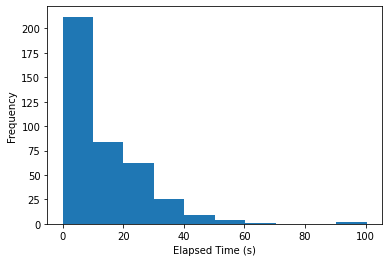

In [ ]:
times = [it2.times[i] - it2.times[i-1] for i in range(1, len(it2.times))]
plt.hist(times)
plt.xlabel('Elapsed Time (s)')
plt.ylabel('Frequency');

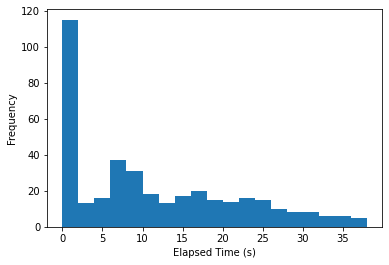

In [ ]:
plt.hist(times, bins=range(0, 40, 2))
plt.xlabel('Elapsed Time (s)')
plt.ylabel('Frequency');

In [ ]:
statistics.mean(times)

12.974709617762937

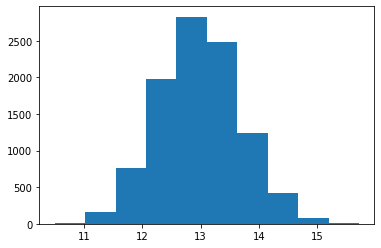

In [ ]:
import random
time_means = list()
for _ in range(10000):
  time_means.append(statistics.mean(random.choices(times, k=len(times))))
plt.hist(time_means);

However, the mean time to analyze a text has increased. I would for like it to be closer to 9 seconds per page.
* Do not re-do just because of the letter height if the confidence is already good (above, say, 90). [DONE]
* Take your initial scale back down to 1.5 [TODO (tentative)]

For transparency, I should note that 9 seconds per page is about the time it takes for Tesseract to analyze a page without any of the tricks I have been using to try to improve accuracy. The number, 9 seconds, was chosen because I want to be more accurate than the vanilla usage of Tesseract without being slower.

I will also probably omit words that have extremely low confidence -- I think that will reduce the Jaccard distance. So, if confidence is less than, say, 40 (I should probably determine the number empirically), then I will just leave out the word and perhaps replace it with two newlines so that artificial bigrams are not formed. [TODO]

I caught a bug while I was reading the output. In the `rotate` function, I was missing `expand=True`, and so words were being cut off. [DONE]

In the future, I may also want to aim for a median word height 30 pixels instead of 15. [TODO (tentative)]

In [ ]:
pd.array([1, 1, 1, 0], dtype='bool') & pd.array([0, 1, 1, 1], dtype='bool')

<PandasArray>
[False, True, True, False]
Length: 4, dtype: bool

In [ ]:
pd.isna(it2.metadata[90].text[4])

False

## Iteration 3

Fix orientation bug, change confidence metric to exclude whitespace.

See [this spreadsheet](https://docs.google.com/spreadsheets/d/1i-goSXBWIcWnf1hB78vrkEKYmfVu_Een6SJ0J-3TbCA/edit?usp=sharing) for the output.

In [ ]:
with open('development_sample_out5/analysis.pickle', 'rb') as dbfile:
  it3 = pickle.load(dbfile)
it3

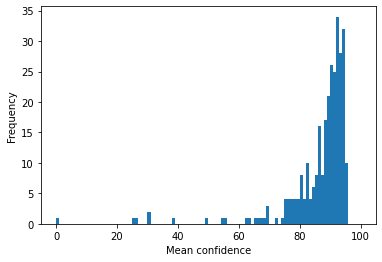

In [ ]:
plt.hist([conf for conf in it3.mean_confidences if conf is not None], bins=range(101))
plt.xlabel('Mean confidence')
plt.ylabel('Frequency');

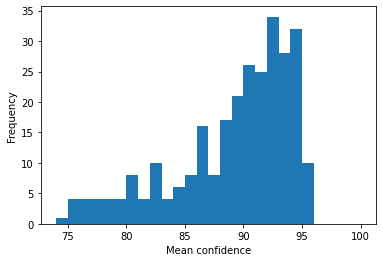

In [ ]:
plt.hist([conf for conf in it3.mean_confidences if conf is not None], bins=range(74, 101))
plt.xlabel('Mean confidence')
plt.ylabel('Frequency');

In [ ]:
mean_confidences = list(
    conf for conf in it3.mean_confidences if not pd.isna(conf))
print('The mean wordwise confidence was {:.4f},\nthe mean pagewise confidence '
  'was {:.4f},\nand {} pages were analyzed with a confidence of less than '
  '75.'.format(
      statistics.mean(
          confidence
          for data in [data for data in it3.metadata if data is not None]
          for confidence in data.conf if confidence > -1
      ),
      statistics.mean(mean_confidences),
      sum(conf < 75 for conf in mean_confidences)
  ))

The mean wordwise confidence was 88.9157,
the mean pagewise confidence was 86.8028,
and 20 pages were analyzed with a confidence of less than 75.


I calculate the pagewise confidence using the previous metric to show that it is also about the same:

In [ ]:
statistics.mean(
    data.conf[data.conf >= 0].mean()
    for data in [data for data in it3.metadata if data is not None]
)

87.39070213497254

The metrics make the current iteration look slightly worse, but I suspect that this is because the metrics are more honest.

In [ ]:
times = list(it3.times[i] - it3.times[i-1] for i in range(1, len(it3.times)))
statistics.mean(times)

10.775398997137122

I have no idea why the average elapsed time went down.

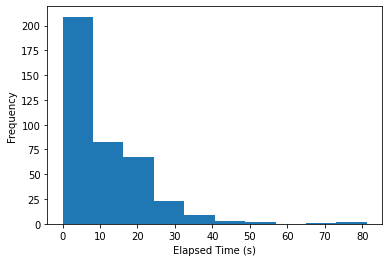

In [ ]:
plt.hist(times)
plt.xlabel('Elapsed Time (s)')
plt.ylabel('Frequency');

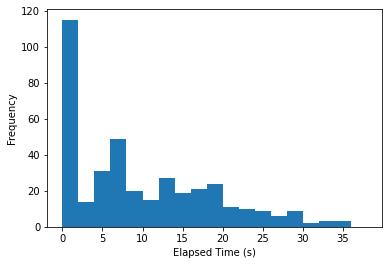

In [ ]:
plt.hist(times, bins=range(0, 40, 2))
plt.xlabel('Elapsed Time (s)')
plt.ylabel('Frequency');

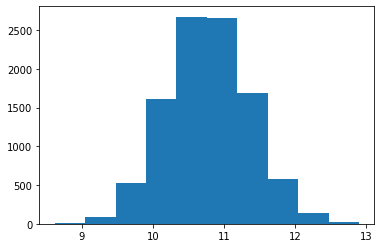

In [ ]:
import random
time_means = list()
for _ in range(10000):
  time_means.append(statistics.mean(random.choices(times, k=len(times))))
plt.hist(time_means);

This is unexpected, and qualitatively speaking, it doesn't look like it happened randomly. However, it might not be replicable: Maybe Google Colab was for some reason running faster during one runtime than in another, maybe because of how resources were being allocated behind the scenes.

In [ ]:
with open('development_sample_out6/analysis.pickle', 'rb') as dbfile:
  it3_2 = pickle.load(dbfile)
it3_2
times2 = list(it3_2.times[i] - it3_2.times[i-1] for i in range(1, len(it3_2.times)))
statistics.mean(times2)

12.021645559105359

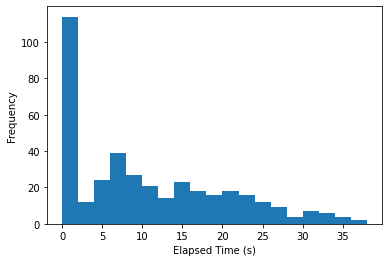

In [ ]:
plt.hist(times2, bins=range(0, 40, 2))
plt.xlabel('Elapsed Time (s)')
plt.ylabel('Frequency');

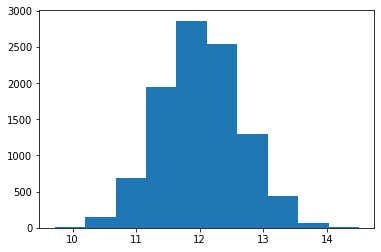

In [ ]:
import random
time_means2 = list()
for _ in range(10000):
  time_means2.append(statistics.mean(random.choices(times2, k=len(times2))))
plt.hist(time_means2);

In [ ]:
abs_diff_of_means = abs(statistics.mean(times2) - statistics.mean(times))
abs_diff_of_means

1.2462465619682366

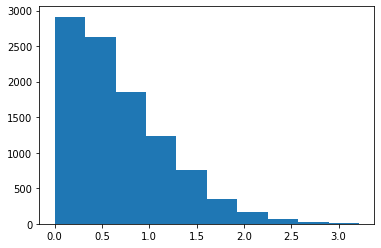

In [ ]:
boot_diffs_of_means = list()
combined = times + times2
for _ in range(10000):
  boot_diffs_of_means.append(abs(
      statistics.mean(random.choices(combined, k=len(times2)))
      - statistics.mean(random.choices(combined, k=len(times)))
  ))
plt.hist(boot_diffs_of_means);

After this, I still do not know whether time trial results are replicable. I have not rejected the null.

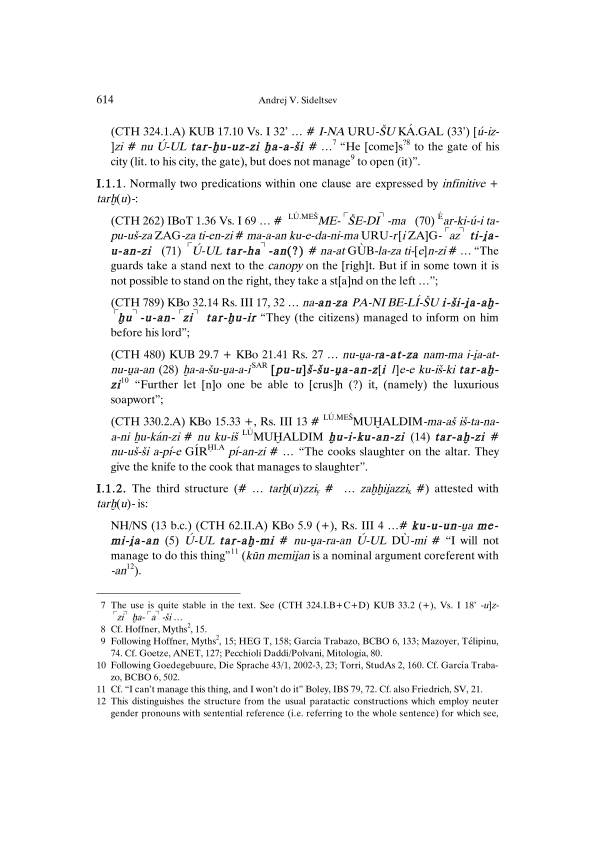

In [ ]:
import fitz
from PIL import Image
doc = fitz.open('development_sample.pdf')
def image(document, page_number, resolution=5):
  pix = document.get_page_pixmap(
      page_number, matrix=fitz.Matrix(resolution, resolution))
  return Image.frombytes(
      ("RGBA" if pix.alpha else "RGB"),
      [pix.width, pix.height], pix.samples
      )
image(doc, 8, 1)

In [ ]:
doc.load_page(8).get_text('words')

[(258.4800109863281,
  96.43009185791016,
  339.10400390625,
  105.4238510131836,
  '��������������������',
  0,
  0,
  0),
 (96.4800033569336,
  94.94401550292969,
  113.71200561523438,
  105.9120101928711,
  '���',
  0,
  1,
  0),
 (110.63999938964844,
  127.10398864746094,
  500.9519958496094,
  138.07199096679688,
  '���������������������������������������������������������������������',
  1,
  0,
  0),
 (110.63999938964844,
  141.98399353027344,
  127.31999969482422,
  152.95199584960938,
  '����',
  1,
  1,
  0),
 (127.44000244140625,
  141.98399353027344,
  190.9199981689453,
  152.95199584960938,
  '����������',
  1,
  1,
  1),
 (190.12200927734375,
  141.98399353027344,
  264.3599853515625,
  152.95199584960938,
  '�������������',
  1,
  1,
  2),
 (263.5619812011719,
  141.98399353027344,
  308.2799987792969,
  152.95199584960938,
  '��������',
  1,
  1,
  3),
 (308.3999938964844,
  137.662353515625,
  501.57598876953125,
  152.95199584960938,
  '���7�������������8������������

In [ ]:
text = doc.load_page(8).get_text()

In [ ]:
type(text)

str

In [ ]:
text.translate('eng')

'��������������������\n���\n���������������������������������������������������������������������\n���� ���������� ������������� �������� ���7�������������8��������������������\n������������������������������������������������������9����������������\n�\n���������������������������������������������������������������������������������\n�����������\n�������������������������������������������\n�\n�����\n�\n������������������������\n��������������������������������������������������������������\n�\n��\n�\n�������\n��������������\n�\n�����������\n�\n���������������������������������������������\n���������������������������������������������������������������������������������\n������������������������������������������������������������������������\n�\n�������������������������������������������������������������������������\n���\n�������\n���\n�� ��������������������������������������������������������\n������������������\n�\n���������������������������������������������������������������

In [ ]:
text.encode('utf-8')

b'\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\n\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\n\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\x

## Iteration 4

This time I tried to focus only on speed.

However, there was another issue which I was compelled to fix. Some pages had nonstandard character encodings, which forced me to render and then OCR them, even though there were no images. Before, I had just been extracting "�" from those pages -- that is the Unicode placeholder character.

See [this spreadsheet](https://docs.google.com/spreadsheets/d/1axFFRIwsCmtU5iZ5LXStwE9m5P-u_FitzuZvui73hVU/edit?usp=sharing) for the output.

UPDATE: the code I had added to address the corrupted pages (with "�" symbols) had a logical bug that I think has been fixed. The result is that the "�" symbols are still in the above spreadsheet, but from now on I think they have been addressed.

I am pleased to observe that the small speed optimizations that I made did not appreciably reduce confidence scores, which are my indirect way of predicting accuracy. It seems possible that the only reason why the previous iteration had higher confidence scores may have been simply that I was doing more analyses and choosing from the best, according to confidence score -- not that I was necessarily seeing real improvement in terms of ground-truth accuracy.

In [ ]:
with open('development_sample_out7/analysis.pickle', 'rb') as dbfile:
  it4 = pickle.load(dbfile)
it4

In [ ]:
mean_confidences = list(
    conf for conf in it4.mean_confidences if not pd.isna(conf))
print('The mean wordwise confidence was {:.4f},\nthe mean pagewise confidence '
  'was {:.4f},\nand {} pages were analyzed with a confidence of less than '
  '75.'.format(
      statistics.mean(
          confidence
          for data in [data for data in it4.metadata if data is not None]
          for confidence in data.conf if confidence > -1
      ),
      statistics.mean(mean_confidences),
      sum(conf < 75 for conf in mean_confidences)
  ))

The mean wordwise confidence was 88.6046,
the mean pagewise confidence was 86.6851,
and 19 pages were analyzed with a confidence of less than 75.


In [ ]:
times = list(it4.times[i] - it4.times[i-1] for i in range(1, len(it4.times)))
statistics.mean(times)

9.435988260689834

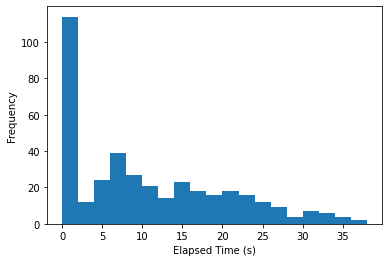

In [ ]:
plt.hist(times2, bins=range(0, 40, 2))
plt.xlabel('Elapsed Time (s)')
plt.ylabel('Frequency');

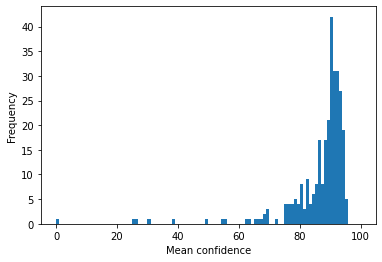

In [ ]:
plt.hist([conf for conf in it4.mean_confidences if conf is not None], bins=range(101))
plt.xlabel('Mean confidence')
plt.ylabel('Frequency');

mupdf: expected string or endbfrange


(array([1.11e+03, 3.98e+02, 5.90e+01, 1.30e+01, 8.00e+00, 2.00e+00,
        1.00e+00, 3.00e+00, 0.00e+00, 1.00e+00]),
 array([    0. ,  2908.2,  5816.4,  8724.6, 11632.8, 14541. , 17449.2,
        20357.4, 23265.6, 26173.8, 29082. ]),
 <a list of 10 Patch objects>)

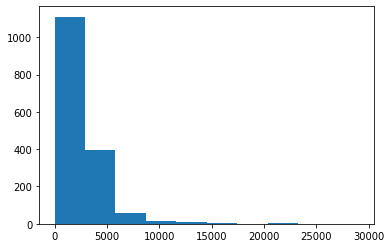

In [ ]:
import fitz
large_sample = fitz.open('large_sample.pdf')
lengths = list()
for page in large_sample:
  lengths.append(len(page.get_text()))
plt.hist(lengths)

In [ ]:
original_text = '�������������������������'
len([a for a in original_text if a == '�'])

25

## Iteration 5

Here, I replace langdetect with CLD3 as the language detection mechanism.

See [this spreadsheet](https://docs.google.com/spreadsheets/d/1fDODNRPd_Gm6OD76MBCup3xnAMYVsp2FFIDPrXunpoU/edit?usp=sharing) for the output.

We see a slight decrease in the proxy performance measurements. This slight decrease is probably not statistically significant, but it is not the increase in performance that was hoped for. This run has provided no evidence that the new language detector offered improvement of any sort.

In [4]:
src = 'development_sample.pdf'
out = 'development_sample_out8'
Text(src, out).save_ocr()

/content/drive/.shortcut-targets-by-id/1W2EROe2FItlaK99U-WY_qaBOc2UD_LI0/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/tesseract_manager.py:247: UserWarning: Failed to analyze image.
  warnings.warn('Failed to analyze image.')

/content/drive/.shortcut-targets-by-id/1W2EROe2FItlaK99U-WY_qaBOc2UD_LI0/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/tesseract_manager.py:247: UserWarning: Failed to analyze image.
  warnings.warn('Failed to analyze image.')

/content/drive/.shortcut-targets-by-id/1W2EROe2FItlaK99U-WY_qaBOc2UD_LI0/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/tesseract_manager.py:303: UserWarning: OCR failed: (1, 'Error opening data file /usr/share/tesseract-ocr/4.00/tessdata/dan_frak.traineddata Please make sure the TESSDATA_PREFIX environment variable is set to your "tessdata" directory. Failed loading language \'dan_frak\' Tesseract couldn\'t load any languages! Could not initialize tesseract.')
  warnings.warn('OCR failed: ' + str(e))

/content/drive/.shortcut-targets-by-id/1W2EROe

DEBUG: No language found corresponding to iw


/content/drive/.shortcut-targets-by-id/1W2EROe2FItlaK99U-WY_qaBOc2UD_LI0/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/tesseract_manager.py:247: UserWarning: Failed to analyze image.
  warnings.warn('Failed to analyze image.')

/content/drive/.shortcut-targets-by-id/1W2EROe2FItlaK99U-WY_qaBOc2UD_LI0/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/tesseract_manager.py:247: UserWarning: Failed to analyze image.
  warnings.warn('Failed to analyze image.')

/content/drive/.shortcut-targets-by-id/1W2EROe2FItlaK99U-WY_qaBOc2UD_LI0/AWCA/Colab_notebooks/OCR/pDonovan/awca-ocr/tesseract_manager.py:303: UserWarning: OCR failed: (1, 'Tesseract Open Source OCR Engine v4.0.0-beta.1 with Leptonica Warning. Invalid resolution 0 dpi. Using 70 instead. Estimating resolution as 717 Too few characters. Skipping this page Too few characters. Skipping this page Error during processing.')
  warnings.warn('OCR failed: ' + str(e))

/content/drive/.shortcut-targets-by-id/1W2EROe2FItlaK99U-WY_qaBOc2UD_LI0/AWCA/Colab_not

In [5]:
with open('development_sample_out8/analysis.pickle', 'rb') as dbfile:
  it5 = pickle.load(dbfile)
it5

In [6]:
mean_confidences = list(
    conf for conf in it5.mean_confidences if not pd.isna(conf)
)
print('The mean wordwise confidence was {:.4f},\nthe mean pagewise confidence '
  'was {:.4f},\nand {} pages were analyzed with a confidence of less than '
  '75.'.format(
      statistics.mean(
          confidence
          for data in [data for data in it5.metadata if data is not None]
          for confidence in data.conf if confidence > -1
      ),
      statistics.mean(mean_confidences),
      sum(conf < 75 for conf in mean_confidences)
  ))

The mean wordwise confidence was 88.5881,
the mean pagewise confidence was 86.5226,
and 21 pages were analyzed with a confidence of less than 75.


In [7]:
times = list(it5.times[i] - it5.times[i-1] for i in range(1, len(it5.times)))
statistics.mean(times)

9.986262056761817

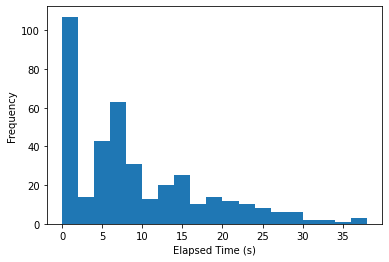

In [8]:
plt.hist(times, bins=range(0, 40, 2))
plt.xlabel('Elapsed Time (s)')
plt.ylabel('Frequency');

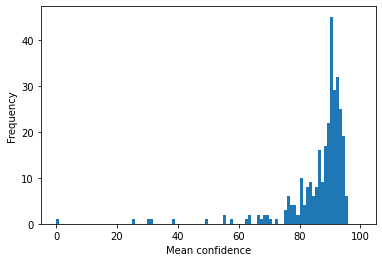

In [10]:
plt.hist([conf for conf in it5.mean_confidences if conf is not None], bins=range(101))
plt.xlabel('Mean confidence')
plt.ylabel('Frequency');

From a qualitative inspection of the output, it seems that CLD3 is more inclusive than `langdetect` in the sense that it is more likely to guess an uncommon language (especially Maltese -- it seems weirdly likely to guess Maltese). The two disagreed with each other about 10% of the time, and it is still not obvious which of the two is less wrong.

It is worth noting, however, that this may just reflect the expansion of the list of possible languages to include more than just the ones that we know are in the corpus. So it may well be the case that the two language detectors are actually contributing nothing at all to the difference that is being observed here.